# Example on Creating New Partial Differential Equations

This example uses the elixer script from: 

https://github.com/trixi-framework/Trixi.jl/blob/main/examples/dgmulti_2d/elixir_navierstokes_convergence.jl

This notebook is based on a simple Navier-Stokes problem with periodic bondary conditions in the x-direction and walls in the y-direction. The top y-boundary has a moving wall (No-Slip). This is called Couette Flow which is described in this wikipedia article: 

https://en.wikipedia.org/wiki/Couette_flow

In [1]:
VERSION

v"1.10.5"

In [2]:
] activate .

  Activating new project at `~/TRIXI`


In [3]:
using OrdinaryDiffEq
using Trixi
using Plots

# 2D Gaussian Beam Slowly Varrying Approximation

We will write the 2D Slowly Varying Enevelope Approximation for Optics in TRIXI. The Following equation is found in **Fundamentals of Nonlinear Optics** by Powers (Eqn 10.79)



This is based off the tutorial: https://trixi-framework.github.io/Trixi.jl/stable/tutorials/adding_new_scalar_equations/

and elixer example on advection:
https://github.com/trixi-framework/Trixi.jl/blob/main/examples/structured_2d_dgsem/elixir_advection_basic.jl

and src codes: https://github.com/trixi-framework/Trixi.jl/blob/main/src/equations/maxwell_1d.jl

The time dependent paraxial wave equation with no dispersion is:

\begin{equation}
    \frac{\partial}{\partial t} A + v_{g} \frac{\partial}{\partial z} A - i\frac{v_{g}}{2 k_{0}} \nabla^{2} A = 0
\end{equation}

There is one issue with `Trixi.jl`: It does not handle complex values. Thus, we will need to split our SVEA paraxial system into the real and imaginary parts. 

We define the amplitude: 

\begin{equation}
    \mathbf{A}\left( z, r_{\perp}, t \right) = A_{r}\left( z, r_{\perp}, t \right) + i  A_{i}\left( z, r_{\perp}, t \right)
\end{equation}

Plugging into the SVEA equation: 

\begin{equation}
    \begin{aligned}
    &\frac{\partial}{\partial t} \left( A_{r} + i A_{i}  \right) + v_{g} \frac{\partial}{\partial z} \left( A_{r} + i A_{i}  \right)  - i\frac{v_{g}}{2 k_{0}} \nabla^{2} \left( A_{r} + i A_{i}  \right)  = 0 \\
    \Rightarrow& \frac{\partial}{\partial t} A_{r} + v_{g} \frac{\partial}{\partial z}  A_{r}  + \frac{v_{g}}{2 k_{0}} \nabla^{2}  A_{i}  \: + \: i\left( \frac{\partial}{\partial t} A_{i} + v_{g} \frac{\partial}{\partial z}  A_{i}  - \frac{v_{g}}{2 k_{0}} \nabla^{2}  A_{r} \right) = 0
    \end{aligned}
\end{equation}

We then set the real and imaginary parts to be a coupled system of equations:

\begin{equation}
    \begin{aligned}
    &\frac{\partial}{\partial t} A_{r} + v_{g} \frac{\partial}{\partial z}  A_{r}  + \frac{v_{g}}{2 k_{0}} \nabla^{2}  A_{i} = 0 \\
    &\frac{\partial}{\partial t} A_{i} + v_{g} \frac{\partial}{\partial z}  A_{i}  - \frac{v_{g}}{2 k_{0}} \nabla^{2}  A_{r} = 0 
    \end{aligned}
\end{equation}

# Setting up the SVEA (Paraxial Wave) Equation

## Hyperbolic Advection Term

The hyperbolic advection term of the SVEA Paraxial Wave equation is just: 

\begin{equation}
    \frac{\partial}{\partial t} A + v_{g} \frac{\partial}{\partial z} A 
\end{equation}

The linear hyperbolic advection equation is already implemented in `Trixi.jl`. All we need to do is use the `LinearScalarAdvectionEquation2D()` function which assumes the form of: 

\begin{equation}
    \frac{\partial}{\partial t} A + v_{z} \frac{\partial}{\partial z} A + v_{y} \frac{\partial}{\partial y} A
\end{equation}

`LinearScalarAdvectionEquation2D()` takes in the user input for the advection velocity ($v_z ,\: v_y$). Since the SVEA has only an advection term in the x-direction, we can set the transverse direction to zero ($v_{y} \rightarrow 0$).

Below we set up the linear hyperbolic advection equation. Note that we need to do this for the real and imaginary parts ($A_{r}, A_{i}$).

In [4]:
# advection_velocity = (1.0,0.0)
# equations_hyperbolic_real = LinearScalarAdvectionEquation2D(advection_velocity);
# equations_hyperbolic_imag = LinearScalarAdvectionEquation2D(advection_velocity);

Let's import various `Trixi.jl` funcitons we need to define our new equations

In [5]:
# Define new physics
using Trixi
using Trixi: AbstractEquations, get_node_vars
import Trixi: varnames, default_analysis_integrals, flux, max_abs_speed_naive,
              have_nonconservative_terms

In [6]:
# Since there is no native support for the Linear Advection equation with two variables
# variables: Ar, Ai
struct LinearAdvectionEquation2v2D{T <: Real} <: AbstractEquations{2 #= spatial dimension =#,
                                                                   2 #= two variables (u,a) =#}
    speed_of_light::T #constant speed of light (vacuum)
    k0::T #constant central wavenumber 
end

We define our new 2-variable, 2-dimension linear sacalar advection equations as shown above. We create a new struct that is a `Trixi.jl` type of `AbstractEquations` (hence the `<:`). `AbstractEquations{a,b}` is a type where the the `a` is the spatial dimensions of the system, and `b` are the variables of the system. 

Notice that we add the `{T <: Real}` to initialize the struct `LinearAdvectionEquation2v2D` to take in `T` values that belong to the `Real` type of Julia. 

Inside the struct, we want it to hold the speed of light and the central wavenumber: `speed_of_light` and `k0`, respectively

Next we need to define the variable names of our 2-variable, 2-dimensional linear scalar advection equation. The variables will be the real and imaginary part ($A_{r}$, $A_{i}$). These two variables are the conservative and the primitive so we use multiple-dispatch to overload the `Trixi.jl` function `varnames()`

In [7]:
varnames(::typeof(cons2cons), ::LinearAdvectionEquation2v2D) = ("Ar", "Ai")
varnames(::typeof(cons2prim), ::LinearAdvectionEquation2v2D) = ("Ar", "Ai")

default_analysis_integrals(::LinearAdvectionEquation2v2D) = ()

default_analysis_integrals (generic function with 6 methods)

### Defining Flux

We need to identify the flux for the 2v2D Linear Advection Equations:

\begin{equation}
    \mathbf{F} = \begin{pmatrix}
    f_z \\
    f_y
    \end{pmatrix} = c \begin{pmatrix}
    A_{r} \\
    A_{i}
    \end{pmatrix}
\end{equation}


As shown above, the flux is just simpy the group velocity ($v_{g}$) which in vacuum is just the speed of light. 

In [8]:
# Calculate 1D flux for a single point
@inline function flux(u, orientation::Integer,
                      equations::LinearAdvectionEquation2v2D)
    Ar, Ai = u
    return SVector(equations.speed_of_light * Ar, equations.speed_of_light * Ai)
end

flux (generic function with 51 methods)

The flux function requires the input variable (which can be a scalar or vector), orientation (z or y directions), and equation type. 

We first unpack the scalar terms from the input variable `u` which should be a vector of the two scalar variables $A_{r}$ and $A_{i}$. 

Next we return a static vector `SVector()` of the fluxes as shown above.

### Defining Speed Limits

We need to calculate the maximum speed possible for our fluxes. We do this by multiple-dispatching the `Trixi.jl` function `max_abs_speed_naive()`. 

In [9]:
# Calculate maximum wave speed for local Lax-Friedrichs-type dissipation
@inline function max_abs_speed_naive(u_ll, u_rr, orientation::Int,
                                     equations::LinearAdvectionEquation2v2D)
    λ_max = equations.speed_of_light
end

@inline have_constant_speed(::LinearAdvectionEquation2v2D) = True()

@inline function max_abs_speeds(equations::LinearAdvectionEquation2v2D)
    return equations.speed_of_light
end

max_abs_speeds (generic function with 1 method)

We are now done creating our new 2-variable, 2-dimensional scalar Advection equations. 

## Parabolic Diffusion Term (Diffraction)

The parabolic diffusion (diffraction) term of the SVEA Paraxial Wave equation is just: 

\begin{equation}
    \frac{\partial}{\partial t} A - i\frac{v_{g}}{2 k_{0}} \nabla^{2} A
\end{equation}

But we split it up into the real and imaginary parts to get rid of the complex values: 

\begin{equation}
    \begin{aligned}
        &\frac{\partial}{\partial t} A_{r} + \frac{v_{g}}{2 k_{0}} \nabla^{2} A_{i} \\
        &\frac{\partial}{\partial t} A_{i} - \frac{v_{g}}{2 k_{0}} \nabla^{2} A_{r}
    \end{aligned}
\end{equation}

### Creating Parabolic Equation Struct

We need to make an equation struct to hold all the information for the diffraction term. We can use the code from the tutorial: https://trixi-framework.github.io/Trixi.jl/stable/tutorials/adding_new_parabolic_terms/

In [10]:
struct ConstantAnisotropicDiffusion2D{E, T} <: Trixi.AbstractEquationsParabolic{2, 2, GradientVariablesConservative}
    # diffusivity::T
    equations_hyperbolic::E
    speed_of_light::T # c
    k0::T # k0 wavenumber
end

Creating the abstract struct: 

`struct ConstantAnisotropicDiffusion2D{E, T}`

where the `E` is the abstract type which will be used to refer to the `equation` type, and the `T` will be used to refer to the diffusivity type. In this case, because it is 2D it will be a 2D vector type.

This abstract struct allows for anisotropic diffusion in the longitudinal and transverse direction. In this case, the SVEA is not anisotropic but we will leave it in case users want to play around with it. 

This struct will belong to (`<:`):

`Trixi.AbstractEquationsParabolic{2, 1, GradientVariablesConservative}`

Where the `2` is the number of dimensions, `1` is the number of variables, and `GradientVariablesConservative` is chosen because the hyperbolic system is conservative. This is the case because there is no dissipation mechanism (i.e. optical absorption from air).

Next we need to map the parabolic variables to the hyperbolic variables. `Trixi.jl` already has a function to obtain the variable names: `varnames()`. Since the `LinearScalarAdvectionEquation2D` is already part of the `Trixi.jl` package and part of the `equation` abstract type, `varnames()` will be able to act and return something for the hyperbolic terms. 

We need to define a function via multiple-dispatch to do the same for our parabolic terms. We do this below:

In [11]:
varnames(variable_mapping, equations_parabolic::ConstantAnisotropicDiffusion2D) =
  varnames(variable_mapping, equations_parabolic.equations_hyperbolic)

varnames (generic function with 73 methods)

In this new multiple-dispatched `varnames()`, the first input argument is the same as the the one from the `Trixi.jl` package. `variable_mapping` is the map from one set of variables to the other. 

The second argument then defines our multiple-dispatch where we have define this function to take effect when the second argument is a type `::ConstantAnisotropicDiffusion2D`. When this is the case, it actually just calls the original `varnames()` and inputs the `ConstantAnisotropicDiffusion2D` struct's hyperbolic equations which we defined in the abstract struct above!

### Parabolic Flux

Next, we define the viscous flux function. We assume that the mixed hyperbolic-parabolic system is of the form:

\begin{equation}
    \frac{\partial}{\partial t} A + \frac{\partial}{\partial x} \left[ f_{1}\left( A \right) + g_{1}\left( A, \nabla A \right)  \right] + \frac{\partial}{\partial y} \left[ f_{2}\left( A \right) + g_{2}\left( A, \nabla A \right)  \right] = 0
\end{equation}

where $f_{1}(A)$ and $f_{2}(A)$ are the hyperbolic fluxes. $g_{1}(A, \nabla A)$ and $g_{2}(A \nabla A)$ denotes the viscous fluxes. For anisotropic diffusion, the viscous fluxes are the first and second components of the matrix-vector product involving `diffusivity` and the gradient vector. Here, we specialize the flux to our new parabolic equation type `ConstantAnisotropicDiffusion2D`

However, because we have to scalar values ($A_{r} $, $A_{i}$), we'll follow along the `compressible_navier_stokes_2d.jl` source code, specifically the parabolic diffusion flux for the `CompressibleNavierStokesDiffusion2D`.

https://github.com/trixi-framework/Trixi.jl/blob/1d7b2561ff656cb9b8c826ee8b7ee389a3370917/src/equations/compressible_navier_stokes_2d.jl

In our case, the viscous stress tensor is anisotropic such that: 

\begin{equation}
    \tau_{z} = \frac{v_{g}}{2 k_{0}} \begin{bmatrix}
    0 & 1 \\
    -1 & 0
    \end{bmatrix}
\end{equation}

and

\begin{equation}
    \tau_{y} = \frac{v_{g}}{2 k_{0}} \begin{bmatrix}
    0 & 1 \\
    -1 & 0
    \end{bmatrix}
\end{equation}

so that the diffusive flux in the z-direction is: 

\begin{equation}
    \tau_{z}\cdot \begin{pmatrix}
    A_{r} \\
    A_{i}
    \end{pmatrix} = \frac{v_{g}}{2 k_{0}} \begin{pmatrix}
    A_{i} \\
    -A_{r}
    \end{pmatrix}
\end{equation}

and the diffusive flux in the transverse y-direction is: 

\begin{equation}
    \tau_{y}\cdot \begin{pmatrix}
    A_{r} \\
    A_{i}
    \end{pmatrix} = \frac{v_{g}}{2 k_{0}} \begin{pmatrix}
    A_{i} \\
    -A_{r}
    \end{pmatrix}
\end{equation}

In [12]:
# Explicit formulas for the diffusive Navier-Stokes fluxes are available, e.g., in Section 2
# of the paper by Rueda-Ramírez, Hennemann, Hindenlang, Winters, and Gassner
# "An Entropy Stable Nodal Discontinuous Galerkin Method for the resistive
#  MHD Equations. Part II: Subcell Finite Volume Shock Capturing"
# where one sets the magnetic field components equal to 0.
function flux(u, gradients, orientation::Integer, equations::ConstantAnisotropicDiffusion2D)
    
    # Here `gradients` is assumed to contain the gradients of the primitive variables (rho, v1, v2, T)
    # either computed directly or reverse engineered from the gradient of the entropy variables
    # by way of the `convert_gradient_variables` function.
    dArdz, dAidz = gradients[1]
    dArdy, dAidy = gradients[2]

    # Components of viscous stress tensor

    tau_12 = equations.speed_of_light*0.5/equations.k0
    tau_21 = -equations.speed_of_light*0.5/equations.k0
    
    if orientation == 1
        # viscous flux components in the x-direction
        f1 = tau_12 * dAidz
        f2 = tau_21 * dArdz

        return SVector(f1, f2)
    else # if orientation == 2
        # viscous flux components in the y-direction
        g1 = tau_12 * dAidy
        g2 = tau_21 * dArdy

        return SVector(g1, g2)
    end
end

flux (generic function with 52 methods)

# Putting it All Together

## Initialize Equations

Let's initialize the hyperbolic advection equations. We need to define the speed of light and wavenumber. Let's also define the central wavelength and central frequency of our laser.

We define the group velocity as the group velocity in vacuum: $v_g = c$

While $k_0$ is the central wave number. We'll use a central wavelength of $\lambda_0 = 1 \mu \mathrm{m}$

In [65]:
c = 2.998e8 #m/s speed of light in vacuum
l0 = 1.0e-6 #central wavelength in meters
k0 = 2.0*pi/l0 #central wavenumber
omega0 = c*k0 ; #central angular frequency (2*pi f)

We'll use the wavelength as the normalization for the space variables (z,y)

Let's now define our advection equation. We will normalize the speed to the speed of light and the length to our total length of the simulation. Let's say we want to see the laser travel: 

$$ L = 10 \:\mathrm{mm}$$

This will be our normalization length. So then our wavenumber needs to be normalized as follows: 

In [66]:
Lnorm = 10.0e-2 #normalization factor
l0norm = l0/Lnorm #normalized wavelength
k0norm = 2.0*pi/l0norm #normalized wavenumber

cnorm = 1.0 #normalized speed of light
Tnorm = Lnorm/c
omega0norm = omega0*Tnorm

println("Normalization Length: ", Lnorm)
println("Normalized wavelength: ", l0norm)
println("Normalized wavenumber: ", k0norm)
println("Normalized speed of light: ", cnorm)
println("Normalization time: ", Tnorm)

Normalization Length: 0.1
Normalized wavelength: 9.999999999999999e-6
Normalized wavenumber: 628318.5307179587
Normalized speed of light: 1.0
Normalization time: 3.3355570380253507e-10


Notice that we also normalized time by the speed of light and total distance of travel. We will use this for the initial conditions

Now let's initialize our hyperbolic equations

In [67]:
equations_hyperbolic = LinearAdvectionEquation2v2D(cnorm, k0)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ LinearAdvectionEquation2v2D                                                                      │
│ ═══════════════════════════                                                                      │
│ #variables: ………………………………………………… 2                                                                │
│ │ variable 1: …………………………………………… Ar                                                               │
│ │ variable 2: …………………………………………… Ai                                                               │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

Note that in defining `equations_hyperbolic` we use to inputs into our custom `LinearAdvectionEquation2v2D()` function. This is because the parametric struct has two variables within it as we defined it: `speed_of_light` and `k0`. This means that we can initialize these parameters of the struct by inputting them as arguments in chronological order. 

Let's now initialize the parabolic part of our equation. Similar to the hyperbolic initialization, we input the arguments for the hyperbolic equations, the speed of light, and wavenumber

In [68]:
equations_parabolic = ConstantAnisotropicDiffusion2D(equations_hyperbolic, cnorm, k0norm)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ ConstantAnisotropicDiffusion2D                                                                   │
│ ══════════════════════════════                                                                   │
│ #variables: ………………………………………………… 2                                                                │
│ │ variable 1: …………………………………………… Ar                                                               │
│ │ variable 2: …………………………………………… Ai                                                               │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

# Initial Conditions

THe initial conditions will be a gaussian beam of the form from Powers Eqn 2.124: 

\begin{equation}
    \mathbf{E}\left( z,r_{\perp},t \right) = \frac{A_0}{2} \exp{\left( -\frac{\alpha z}{2}  \right)} \frac{w_{0}}{w\left( z \right)}\:  \exp{\left( \frac{ -r_{\perp}^2}{w^2(z)} \right)} \:\exp{\left( i k_{0} \frac{r^{2}_{\perp}}{2 R\left( Z \right)} - i \zeta \left( z \right) \right)}  \: \exp{\left( \frac{\left( z - t/c  \right)^{2}}{\tau^{2}_{0}} \right)}     \cos{\left( \omega_{0} t - k_{0} z  \right)} \: \hat{E} 
\end{equation}

where the variable $z$ is the longitudinal direction and $r_{\perp}$ is the transverse direction, and $\alpha$ is the medium's absorption coefficient. In this example, we choose $\alpha = 0$, so no absorption by the medium since it is vacuum.

The $w\left( z \right)$ represents the $1/e$ field amplitude radius:

\begin{equation}
    w\left( z \right) = w_{0} \sqrt{1 + \frac{z}{z_{R}}}
\end{equation}

$w_{0}$ is the beam waist radius at $z=0$ (the focus), and $z_{R}$ is the rayleigh length described by: 

\begin{equation}
    z_{R} = \frac{\pi n w^{2}_{0}}{\lambda}
\end{equation}

and $n$ is the index of refraction.



The radius of curvature is defined as:

\begin{equation}
    R\left( z \right) = z \left( 1 + \left( \frac{z_{R}}{z} \right)^{2}  \right)
\end{equation}

the Guoy phase shift is define as: 

\begin{equation}
    \zeta \left( z \right) = \tan^{-1}{\left( z/z_{R} \right)}  
\end{equation}

Lastly, $\tau_{0}$ is the $1/e$ temporal pulse width. 

In this example, let's assume our beam starts at: $z = 0$, at the focus. 

We can calculate $w_{0}$ and $\tau_{0}$ from the beamwidth Full-Width-Half-Max (FWHM) $r_{FWHM}$ and the temporal pulsewidth $t_{FWHM}$,  formulation via: 

\begin{equation}
    \begin{aligned}
    \tau_{0} &= t_{FWHM}/\sqrt{ 2 \ln{\left(2 \right)} } \\
    w_{0} &= r_{FWHM}/\sqrt{ 2 \ln{\left(2 \right)} } 
    \end{aligned}
\end{equation}

We can now initialize our gaussian beam:

In [91]:
function GaussianA!(A::AbstractArray{ComplexF64}, laserzstart::Float64, Ztot::Float64, t::Float64, zdomain::AbstractArray{Float64}, rdomain::AbstractArray{Float64}, Amp0::Float64, l0::Float64, k0::Float64, omega0::Float64, tau0::Float64, w0::Float64, c::Float64, nindexrefraction::Float64, lnorm::Float64, tnorm::Float64)

    Nz, Nr = size(A)
    dz = (zdomain[2]-zdomain[1])/Nz
    dr = (rdomain[2]-rdomain[1])/Nr

    zR = pi*nindexrefraction*w0^2/l0
    # println("Zr: ", zR)
    wz = 0.0 #initialize wz so loop doesn't re-create it every iteration
    Rz = 0.0 #same for Rz
    Guyoz = 0.0 #same for Guoy Phase
    
    for i in 1:Nz
        zz =  zdomain[1] + (i-1)*dz - laserzstart #zdomain[1] + (i-1)*dz + laserzstart
        for j in 1:Nr
            rr = rdomain[1] + (j-1)*dr
            wz = w0*sqrt(1 + (zz/zR)^2)
            Rz = zstart * (1 + (zR/zz)^2)
            Guoyz = atan(zz/zR)
            # println(wz, " : ", Rz)
            A[i,j] = Amp0 * w0/wz * exp( -rr^2/wz^2 ) * exp(1.0im * k0 *rr^2/(2*Rz) - 1.0im*Guoyz) * exp( -(zz - t/c)^2/tau0^2  ) 

        end
    end

end

GaussianA! (generic function with 1 method)

Let's define our beamwidth and the pulsewidth first:

In [92]:
tfwhm = 25.0e-12 # 1 ns pulsewidth
rfwhm = 100.0e-6 # 100 micron beamwidht

0.0001

In the normalized units:

In [93]:
tfwhmnorm = tfwhm/Tnorm
rfwhmnorm = rfwhm/Lnorm

println("Normalized t-fwhm: ", tfwhmnorm)
println("Normalize r-fwhm: ", rfwhmnorm)

Normalized t-fwhm: 0.07494999999999999
Normalize r-fwhm: 0.001


Let's now calculate the $\tau_0$ and $w_0$

In [94]:
tau0 = tfwhm/sqrt(2*log(2))
w0 = rfwhm/sqrt(2*log(2))

8.49321800288019e-5

We can now define the Rayleigh Length. Because it's vacuum, we use an index of refraction equal to one: $n = 1$

In [95]:
nindexref = 1.0
zR = pi*nindexref*w0^2/l0

0.022661800709135968

We initialize our beam travelling to the right and starting on the right of the focus at: $z = 1 \:\mathrm{mm}$

We can then calculate the beam radius ($w(z)$), radius of curvature ($R(z)$), and Guoy phase shift ($\zeta (z)$)

In [96]:
Lnorm

0.1

In [97]:
zstart = 2.0e-2
wzstart = w0*sqrt(1 + (zstart/zR))
Rzstart = zstart * (1 + (zR/zstart)^2)
Guoyzstart = atan(zstart/zR)

0.7230858682464256

In [98]:
wzstart, Rzstart

(0.00011653185370584573, 0.04567786056902977)

Note that these must also be normalized as follows:

In [99]:
w0norm = w0/Lnorm
tau0norm = tau0/Tnorm

zstartnorm = zstart/Lnorm
wzstartnorm = wzstart/Lnorm #the beam radius is in units of meters
Rzstartnorm = Rzstart/Lnorm #the beam radius of curvature is also in meters
Guoyzstartnorm =Guoyzstart #the guoy phase is unitless and doesn't need to be normalized

0.7230858682464256

Let's choose how many points are in the domain and initialize our `A` matrix

In [100]:
NZ = 500
NR = 200
AA = zeros(ComplexF64, (NZ,NR));
size(AA), length(AA)

((500, 200), 100000)

Let's create our Z-domain and R-domain just to make sure we know where we're at in space

In [104]:
zdomain = [0.0, 1.0*Lnorm]
ZTOT = zdomain[2]-zdomain[1]
ZTOTnorm = ZTOT/Lnorm
rdomain = [-0.01*Lnorm, 0.01*Lnorm]

ZTOT, ZTOTnorm, zdomain, rdomain

(0.1, 1.0, [0.0, 0.1], [-0.001, 0.001])

Normalize the domain values

In [105]:
zdomainnorm = zdomain./Lnorm
rdomainnorm = rdomain./Lnorm

zdomainnorm, rdomainnorm

([0.0, 1.0], [-0.01, 0.01])

Let's get the spatial step sizes

In [106]:
dz = (zdomain[2]-zdomain[1])/NZ
dr = (rdomain[2]-rdomain[1])/NR

1.0e-5

Now let's plut into the our Gaussian function. Play around with the time. The time is set by distance the pulse has travelled. For example, setting `travel = 0.0` is the amplitude at time $t=0$. Setting `travel = 0.07` gets the time required to travel 7cm

In [254]:
travel = 0.07
ttime = travel/c/Tnorm
GaussianA!(AA, zstartnorm, ZTOTnorm, ttime, zdomainnorm, rdomainnorm, 1.0, l0norm, k0norm, omega0*Tnorm, tau0norm, w0norm, 1.0, 1.0, Lnorm, Tnorm)

In [255]:
AAint = abs2.(AA);

Get coordinate points for our plot

In [256]:
Zdomain = [zdomain[1] + (i-1)*dz for i in 1:NZ]
Rdomain = [rdomain[1] + (i-1)*dr for i in 1:NR];

Plot with heatmap

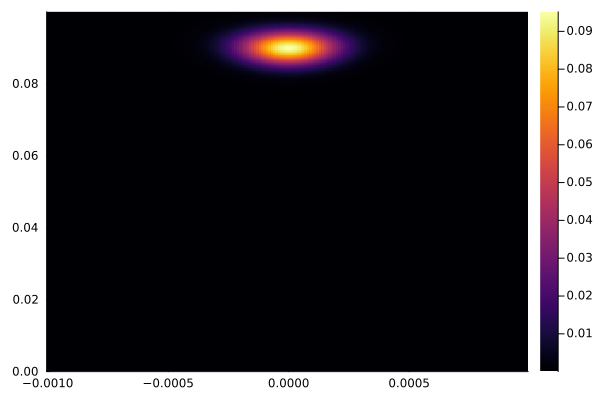

In [258]:
heatmap(Rdomain, Zdomain,  AAint, format=:png)

With the initial condition, we need to separate into real and imaginary parts

In [38]:
Are = real.(AA)
Aim = imag.(AA);

### Setting Initial Conditions to Trixi

Finally we need a variable that will hold the initial conditions to input into `Trixi.jl`

In [249]:
function initial_condition_SVEA(x, t, equations)
    # Amplitude and shift
    A0 = 1.0
    c = 2.998e8 # speed of light m/s
    l0 = 1.0e-6 # central wavelength 
    k0 = 2.0*pi/l0 # central wavenumber
    omega0 = c*k0 # central frequency

    Lnorm = 0.1 #normalization factor
    Tnorm = Lnorm/c
    
    zmin0 = 0.0 #real unnormalized value
    laserzstart = 0.02 #real unnormalized value
    z = x[1]*Lnorm # unnormalize our z coordinate by multiplying by Lnorm
    r = x[2]*Lnorm # unnormalize our r coordinate by multiplying by Lnorm
    tt = t*Tnorm # unnormalize our time by multiplying by Tnorm
    

    tfwhm = 25.0e-12 # 1 ns pulsewidth
    rfwhm = 100.0e-6 # 100 micron beamwidht
    tau0 = tfwhm/sqrt(2*log(2))
    w0 = rfwhm/sqrt(2*log(2))
    # println("tau0: ", tau0)
    # println("w0: ", w0)
    
    
    nindexref = 1.0
    zR = pi*nindexref*w0^2/l0
    #normalize beam variables
    w0norm = w0 #/Lnorm
    tau0norm = tau0 #/Tnorm
    zRnorm = zR #/Lnorm
    
    #normalized beam radius, beam curvature, and guoy phase
    wz = w0*sqrt(1 + (z/zR)^2) #w0norm*sqrt(1 + (z/zRnorm)^2)
    # Rz = z * (1 + (zR/z)^2) #z * (1 + (zRnorm/z)^2)
    inv2Rz = 0.5*z/(z^2 + zR^2)
    Guoyz = atan(z/zR) #atan(z/zRnorm)
    
    #Gaussian Beam Amplitude Equation (Complex Valued)
    A = A0 * w0/wz * exp( -r^2/wz^2 ) * exp(1.0im * k0 *r^2*inv2Rz - 1.0im*Guoyz) * exp( -((z - laserzstart)/c - tt)^2/tau0^2  )
    

    Ar = real(A)
    Ai = imag(A)

    return SVector(Ar, Ai) #Ar, Ai#
end

initial_condition_SVEA (generic function with 1 method)

First we want to normalize the array holding our r,z coordinates

In [250]:
Zdomainnorm = Zdomain/Lnorm
Rdomainnorm = Rdomain/Lnorm;

Let's fill our real `AAAr` and imaginary `AAAi` matrices with the initial conditions

In [251]:
AAAr = zeros(Float64, (length(Zdomain), length(Rdomain)) )
AAAi = zeros(Float64, (length(Zdomain), length(Rdomain)) )

for i in 1:length(Zdomain)
    for j in 1:length(Rdomain)

        AAA = initial_condition_SVEA( [ Zdomainnorm[i], Rdomainnorm[j] ], 0.0, equations_parabolic)
        AAAr[i,j] = AAA[1]
        AAAi[i,j] = AAA[2]
        

    end
end

In [252]:
AAAA = @. AAAr + 1.0im.*AAAi;
AAAA2 = abs2.(AAAA);

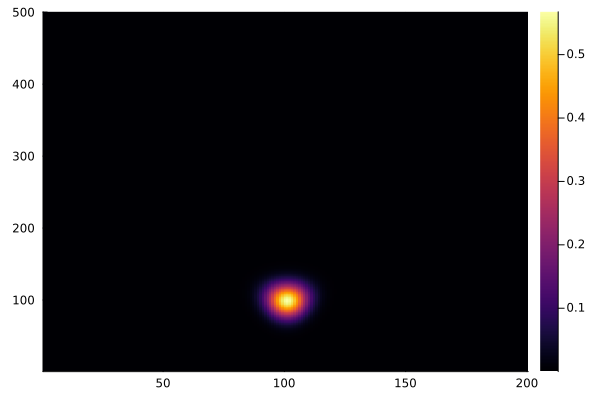

In [253]:
heatmap(AAAA2, format=:png)

## Boundary Conditions: Periodic

For the boundary conditions we will use periodic boundary conditions because that is what is usually done with the Split-Step Fourier Method in solving the Paraxial Wave Equation. 

To use periodic boundary conditions, one does not need to specify a new BC struct as is done in the documentation for the Dirichlet BCs. Instead, periodic BC are implemented when initializing a grid. For example, using the `StructuredMesh()` function we set `periodicity=true` to get periodic BC: 

```
mesh = StructuredMesh(cells_per_dimension,
                coordinates_min, coordinates_max,
                periodicity=true) # set structured mes

```

In [177]:
zdomainnorm, rdomainnorm

([0.0, 1.0], [-0.01, 0.01])

In [178]:
coordinates_min = (zdomainnorm[1], rdomainnorm[1]) # minimum coordinates (min(x), min(y))
coordinates_max = (zdomainnorm[2], rdomainnorm[2]) # maximum coordinates (max(x), max(y))

cells_per_dimension = (500, 200)

(500, 200)

We use `TreeMesh()` because it is capable of using the `SemidiscretizationHyperbolicParabolic`

In [179]:
# Create curved mesh with 16 x 16 elements
# mesh = StructuredMesh(cells_per_dimension, coordinates_min, coordinates_max, periodicity=true)
mesh = TreeMesh(coordinates_min, coordinates_max, 
                periodicity=true, 
                initial_refinement_level = 4,
                n_cells_max = 30_000)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ TreeMesh{2, Trixi.SerialTree{2}}                                                                 │
│ ════════════════════════════════                                                                 │
│ center: …………………………………………………………… [0.5, 0.0]                                                       │
│ length: …………………………………………………………… 1.0                                                              │
│ periodicity: ……………………………………………… (true, true)                                                     │
│ current #cells: ……………………………………… 341                                                              │
│ #leaf-cells: ……………………………………………… 256                                                              │
│ maximum #cells: ……………………………………… 30000                                                            │
└──────────────────────────────────────────────────────────────────────────────────────────

In [180]:
solver = DGSEM(polydeg=3, surface_flux=flux_lax_friedrichs)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DG{Float64}                                                                                      │
│ ═══════════                                                                                      │
│ basis: ……………………………………………………………… LobattoLegendreBasis{Float64}(polydeg=3)                         │
│ mortar: …………………………………………………………… LobattoLegendreMortarL2{Float64}(polydeg=3)                      │
│ surface integral: ………………………………… SurfaceIntegralWeakForm                                          │
│ │ surface flux: ……………………………………… FluxLaxFriedrichs(max_abs_speed_naive)                           │
│ volume integral: …………………………………… VolumeIntegralWeakForm                                           │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

# Semidiscretization

We semidescritize: descritize in space but not in time

We use the `TreeMesh()` because it allows for the use of a hyperbolic-parabolic solver via `SemidiscretizationHyperbolicParabolic`

In [181]:
semi = SemidiscretizationHyperbolicParabolic(mesh,
                                             (equations_hyperbolic, equations_parabolic),
                                             initial_condition_SVEA, solver )
                                             # boundary_conditions=(boundary_conditions_hyperbolic,
                                             #                      boundary_conditions_parabolic))


┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolicParabolic                                                            │
│ ═════════════════════════════════════                                                            │
│ #spatial dimensions: ………………………… 2                                                                │
│ mesh: ………………………………………………………………… TreeMesh{2, Trixi.SerialTree{2}} with length 341                 │
│ hyperbolic equations: ……………………… LinearAdvectionEquation2v2D                                      │
│ parabolic equations: ………………………… ConstantAnisotropicDiffusion2D                                   │
│ initial condition: ……………………………… initial_condition_SVEA                                           │
│ source terms: …………………………………………… nothing                                                          │
│ solver: …………………………………………………………… DG                                                       

# ODE Solver

In [182]:
tspan = (0.0, 0.07/c/Tnorm)
ode = semidiscretize(semi, tspan)
# callbacks = CallbackSet(SummaryCallback())
time_int_tol = 1.0e-9

1.0e-9

In [183]:
summary_callback = SummaryCallback()
alive_callback = AliveCallback(alive_interval = 10)
analysis_interval = 100
analysis_callback = AnalysisCallback(semi, interval = analysis_interval)
callbacks = CallbackSet(summary_callback, alive_callback, analysis_callback);


In [184]:
sol = solve(ode, RDPK3SpFSAL49(); abstol = time_int_tol, reltol = time_int_tol, dt = 1e-5,
            ode_default_options()..., callback = callbacks)
summary_callback() # print the timer summary


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolicParabolic                                                            │
│ ═════════════════════════════════════                                                            │
│ #spatial dimensions: ………………………… 2                                                                │
│ mesh: ………………………………………………………………… TreeMesh{2, Trixi.SerialTree{2}} with length 341                 │
│ hyperbolic equations: ……………………… LinearAdvectionEquation2v2D                                      │
│ parabolic equations: ………………………… ConstantAnisotropicDiffusion2D                                   │
│ initial condition: ……………………………… initial_condition_SVEA                                           

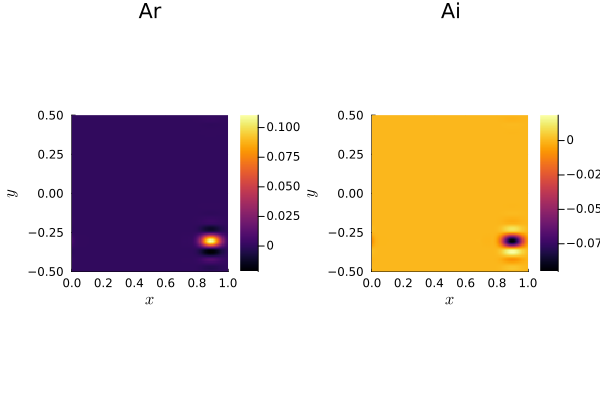

In [188]:
plot(sol, format=:png)

Now no one really understands what the heck is being plotted or how so we need to find a better, more straightforard way to take a look at the data for the solution. 

We use the `Trixi.jl` funciton `PlotData2D` which converts the output of `DifferentialEquations.jl` funciton `sol` into usable data such as 2D matrices for the variables along with x,y coordinates

In [240]:
pd = PlotData2D(sol)

PlotData2DCartesian{Vector{Float64},Vector{Matrix{Float64}},SVector{2, String},Vector{Float64}}(<x>, <y>, <data>, <variable_names>, <mesh_vertices_x>, <mesh_vertices_y>)

Let's get the variable names

In [243]:
pd.variable_names

2-element SVector{2, String} with indices SOneTo(2):
 "Ar"
 "Ai"

Now let's actually get the full intensity by adding the real and imaginary parts: $A = A_{r} + i A_{i}$

And squaring the magnitude

In [246]:
Amp = @. pd.data[1] + 1.0im*pd.data[2];
Amp2 = abs2.(Amp);

We can get the coordinates of the data points by using the `PlotData2D` structure's data of `x` and `y`

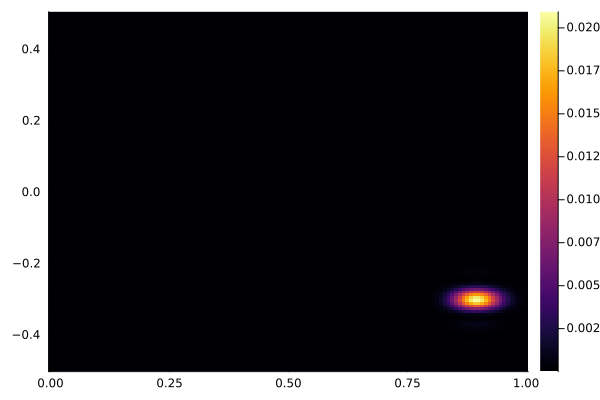

In [247]:
heatmap(pd.x, pd.y, Amp2, format=:png)

# TO DO: Why is it not centered around zero?